# Building a Spam Filter with Naive Bayes

In this project, we're going to study the practical side of the Naive Bayes algorithm (more specifically, the multinomial Naive Bayes algorithm) by building a spam filter for SMS messages.

For this project, our goal is to create a spam filter that classifies new messages with an accuracy greater than 80% — so we expect that more than 80% of the new messages will be classified correctly as spam or ham (non-spam).

To classify messages as spam or non-spam, that is, a computer:

* Learns how humans classify messages.
* Uses that human knowledge to estimate probabilities for new messages — probabilities for spam and non-spam.
* Classifies a new message based on these probability values — if the probability for spam is greater, then it classifies the message as spam. Otherwise, it classifies it as non-spam (if the two probability values are equal, then we may need a human to classify the message).

First task is to "teach" the computer how to classify messages. To do that, we'll use the multinomial Naive Bayes algorithm along with a dataset of 5,572 SMS messages that are already classified by humans.

The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). It can also be downloaded directly from this [link](https://dq-content.s3.amazonaws.com/433/SMSSpamCollection). The data collection process is described in more details on [this page](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/#composition), where you can also find some of the authors' papers.

## Exploring the Dataset

In [1]:
import pandas as pd
#The dataset doesn't have a header row, which means 
# we need to use the header=None parameter, otherwise the first row will be wrongly used as the header row.
# Using the names=['Label', 'SMS'] parameter to name the columns as Label and SMS
sms_original = pd.read_csv('SMSSpamCollection', sep = '\t', header=None, names=['Label', 'SMS'])
sms = sms_original.copy()

In [2]:
sms.head(5)

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
sms.shape
print("The data set has {} rows and {} columns".format(sms.shape[0],sms.shape[1]))

The data set has 5572 rows and 2 columns


In [4]:
sms['Label'].value_counts(normalize = True) * 100

ham     86.593683
spam    13.406317
Name: Label, dtype: float64

From the above, the percentage of messages that is spam is 13.4% and non-spam (ham) is 86.6%

## Training and Test Set

Now that we've become a bit familiar with the dataset, we can move on to building the spam filter.

However, before creating it, it's very helpful to first think of a way of testing how well it works. When creating software (a spam filter is software), a good rule of thumb is that designing the test comes before creating the software. If we write the software first, then it's tempting to come up with a biased test just to make sure the software passes it.

Once our spam filter is done, we'll need to test how good it is with classifying new messages. To test the spam filter, we're first going to split our dataset into two categories:

* A **training set**, which we'll use to "train" the computer how to classify messages.
* A **test set**, which we'll use to test how good the spam filter is with classifying new messages.

We're going to keep 80% of our dataset for training, and 20% for testing (we want to train the algorithm on as much data as possible, but we also want to have enough test data). The dataset has 5,572 messages, which means that:

* The training set will have 4,458 messages (about 80% of the dataset).
* The test set will have 1,114 messages (about 20% of the dataset).

To better understand the purpose of putting a test set aside, let's begin by observing that all 1,114 messages in our test set are already classified by a human. When the spam filter is ready, we're going to treat these messages as new and have the filter classify them. Once we have the results, we'll be able to compare the algorithm classification with that done by a human, and this way we'll see how good the spam filter really is.

For this project, our goal is to create a spam filter that classifies new messages with an accuracy greater than 80% — so we expect that more than 80% of the new messages will be classified correctly as spam or ham (non-spam).

We'll come back to testing toward the end of this project, but for now, let's create a training and a test set. We're going to start by randomizing the entire dataset to ensure that spam and ham messages are spread properly throughout the dataset.

In [5]:
#Randomizing the entire dataset
#'frac=1' parameter to randomize the entire dataset.
#'random_state=1' parameter to make sure the results are reproducible.
sms_randomised = sms.sample(frac = 1, random_state=1)
sms_randomised

,Label,SMS
1078,ham,"Yep, by the pretty sculpture"
4028,ham,"Yes, princess. Are you going to make me moan?"
958,ham,Welp apparently he retired
4642,ham,Havent.
4674,ham,I forgot 2 ask ü all smth.. There's a card on ...
...,...,...
905,ham,"We're all getting worried over here, derek and..."
5192,ham,Oh oh... Den muz change plan liao... Go back h...
3980,ham,CERI U REBEL! SWEET DREAMZ ME LITTLE BUDDY!! C...
235,spam,Text & meet someone sexy today. U can find a d...


In [6]:
#Spliting the randomized dataset into a training and a test set.
#The training accounts for 80% of the dataset, and the remaining 20% of the data is the test set.
training_set_index = round(len(sms_randomised) * 0.80)
training_set = sms_randomised[:training_set_index]
test_set = sms_randomised[training_set_index:]

In [7]:
#Reseting the index labels for both data sets
training_set = training_set.reset_index(drop = True) # drop: Do not try to insert index into dataframe columns
test_set = test_set.reset_index(drop = True)

In [8]:
print('Training set percentages:')
print("For training set, the data set has {} rows and {} columns".format(
    training_set.shape[0],training_set.shape[1]))
print(training_set['Label'].value_counts(normalize = True) * 100, '\n')

print('Test set percentages:')
print("For test set, the data set has {} rows and {} columns".format(
    test_set.shape[0],test_set.shape[1]))
print(test_set['Label'].value_counts(normalize = True) * 100)

Training set percentages:
For training set, the data set has 4458 rows and 2 columns
ham     86.54105
spam    13.45895
Name: Label, dtype: float64 

Test set percentages:
For test set, the data set has 1114 rows and 2 columns
ham     86.804309
spam    13.195691
Name: Label, dtype: float64


From the above percentages and comparing with the original dataset, these percentages are similar to that of the original dataset

## Data Cleaning

The next big step is to use the training set to teach the algorithm to classify new messages.

To calculate all these probabilities, we'll first need to perform a bit of data cleaning to bring the data in a format that will allow us to extract easily all the information we need. Right now, our training and test sets have this kind of format:

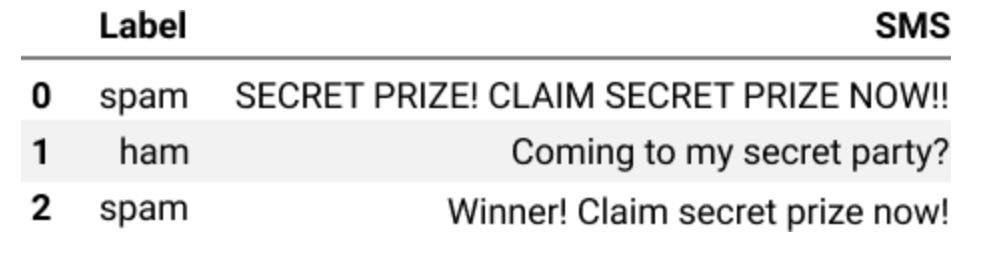

We want it in this format:

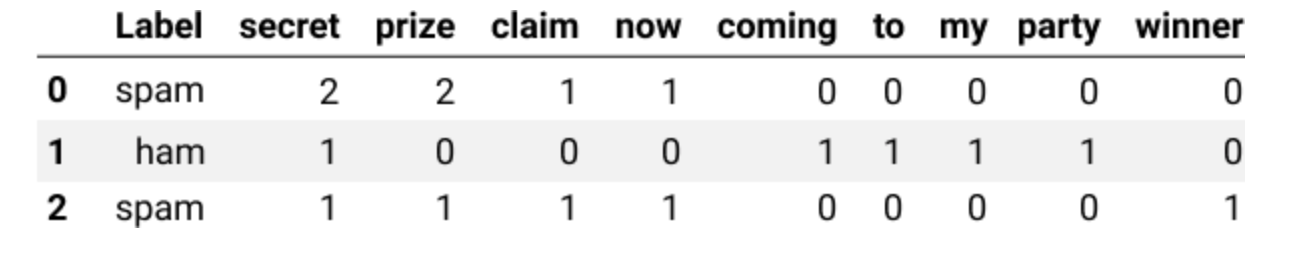

About the transformation above, notice that:

* The `SMS` column doesn't exist anymore.
* Instead, the `SMS` column is replaced by a series of new columns, where each column represents a unique word from the vocabulary.
* Each row describes a single message. For instance, the first row corresponds to the message "SECRET PRIZE! CLAIM SECRET PRIZE NOW!!", and it has the values `spam, 2, 2, 1, 1, 0, 0, 0, 0, 0`. These values tell us that:
    * The message is spam.
    * The word "secret" occurs two times inside the message.
    * The word "prize" occurs two times inside the message.
    * The word "claim" occurs one time inside the message.
    * The word "now" occurs one time inside the message.
    * The words "coming", "to", "my", "party", and "winner" occur zero times inside the message.
* All words in the vocabulary are in lower case, so "SECRET" and "secret" come to be considered to be the same word.
* Punctuation is not taken into account anymore (for instance, we can't look at the table and conclude that the first message initially had three exclamation marks).

## Letter Case and Punctuation

We'll begin the data cleaning process by removing the punctuation and bringing all the words to lower case.

In [9]:
# Before cleaning
training_set.head()

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [10]:
# After cleaning
#'\W' to detect any character that is not from a-z, A-Z or 0-9.
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ')
training_set['SMS'] = training_set['SMS'].str.lower()
training_set.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


## Creating the Vocabulary

As seen in the picture above, with the exception of the "Label" column, every other column in the transformed table above represents a unique word in our vocabulary (more specifically, each column shows the frequency of that unique word for any given message).

We'll eventually bring the training set to that format , but first, let's create a list with all of the unique words that occur in the messages of our training set.

In [11]:
training_set['SMS'] = training_set['SMS'].str.split()
vocabulary = []
for sms in training_set['SMS']:
    for word in sms:
        vocabulary.append(word)
vocabulary = list(set(vocabulary)) #This will remove the duplicates from the vocabulary list.

In [12]:
print('There are', len(vocabulary), 'unique words in our vocabulary')

There are 7783 unique words in our vocabulary


## The Final Training Set

Eventually, we're going to create a new DataFrame. However, we'll first build a dictionary that we'll then convert to the DataFrame we need.

To create the dictionary we need for our training set, we can use the code below, where:

* We start by initializing a dictionary named `word_counts_per_sms`, where each key is a unique word (a string) from the vocabulary, and each value is a list of the length of training set, where each element in the list is a `0`.
    * The code `[0] * 5` outputs `[0, 0, 0, 0, 0]`. So the code `[0] * len(training_set['SMS'])` outputs a list of the length of `training_set['SMS']`, where each element in the list will be a `0`.

* We loop over `training_set['SMS']` using at the same time the `enumerate()` function to get both the index and the SMS message (`index` and `sms`).

    * Using a nested loop, we loop over `sms` (where `sms` is a list of strings, where each string represents a word in a message).
        * We incremenent `word_counts_per_sms[word][index]` by `1`.

In [13]:
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary} #####

for index, sms in enumerate(training_set['SMS']): 
    for word in sms:
        word_counts_per_sms[word][index] += 1


In [14]:
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,knowing,100txt,adjustable,alrite,poem,route,rebooting,pic,thru,addamsfa,...,vaazhthukkal,report,eat,fucking,based,tiring,subscriptions,korli,ten,poop
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
training_set_clean = pd.concat([training_set, word_counts], axis = 1)
training_set_clean.head()

,Label,SMS,knowing,100txt,adjustable,alrite,poem,route,rebooting,pic,...,vaazhthukkal,report,eat,fucking,based,tiring,subscriptions,korli,ten,poop
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Calculating Constants First

Now that we're done with data cleaning and have a training set to work with, we can begin creating the spam filter. Recall that the Naive Bayes algorithm will need to know the probability values of the two equations below to be able to classify new messages:

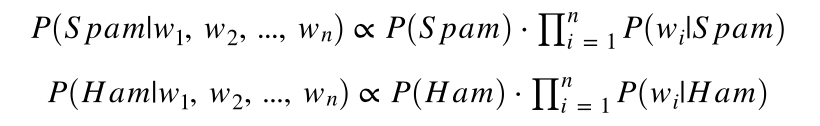

Also, to calculate $P(w_i|Spam)$ and $P(w_i|Ham)$ inside the formulas above, we need to use these equations:

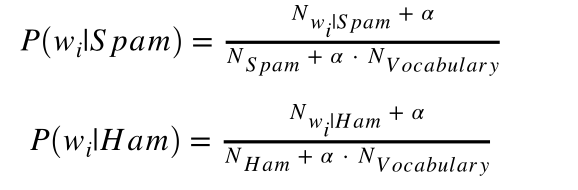

Some of the terms in the four equations above will have the same value for every new message. Let's first calculate:

* P(Spam) and P(Ham)
* NSpam, NHam, NVocabulary

NSpam is equal to the number of words in all the spam messages — it's not equal to the number of spam messages, and it's not equal to the total number of unique words in spam messages.

NHam is equal to the number of words in all the non-spam messages — it's not equal to the number of non-spam messages, and it's not equal to the total number of unique words in non-spam messages.

We'll also use Laplace smoothing and set `α = 1`

In [16]:
# Isolating spam and ham messages first
spam_messages = training_set_clean[training_set_clean['Label'] == 'spam']
ham_messages = training_set_clean[training_set_clean['Label'] == 'ham']

In [17]:
# P(Spam) and P(Ham)
p_spam = len(spam_messages)/len(training_set_clean)
p_ham = len(ham_messages)/len(training_set_clean)

# N_Spam
n_words_per_spam_message = spam_messages['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()

# N_Ham
n_words_per_ham_message = ham_messages['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()

#N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

## Calculating Parameters
Now that we have the constant terms calculated above, we can move on with calculating the parameters $P(w_i|Spam)$ and $P(w_i|Ham)$. Each parameter will thus be a conditional probability value associated with each word in the vocabulary.

The parameters are calculated using the formulas:

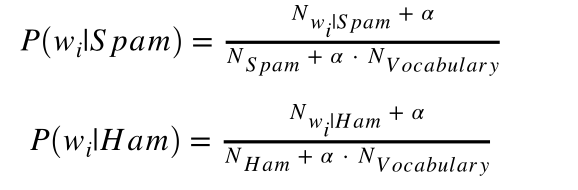

In [18]:
# Initiate parameters
parameters_spam = {unique_word:0 for unique_word in vocabulary}  ####
parameters_ham = {unique_word:0 for unique_word in vocabulary}

# Calculate parameters
for word in vocabulary:
    n_word_given_spam = spam_messages[word].sum()   # spam_messages already defined in a cell above
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
    parameters_spam[word] = p_word_given_spam
    
    n_word_given_ham = ham_messages[word].sum()   # ham_messages already defined in a cell above
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
    parameters_ham[word] = p_word_given_ham

## Classifying A New Message

Now that we've calculated all the constants and parameters we need, we can start creating the spam filter. The spam filter can be understood as a function that:

* Takes in as input a new message (w1, w2, ..., wn)
* Calculates P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn)
* Compares the values of P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn), and:
    * If P(Ham|w1, w2, ..., wn) > P(Spam|w1, w2, ..., wn), then the message is classified as ham.
    * If P(Ham|w1, w2, ..., wn) < P(Spam|w1, w2, ..., wn), then the message is classified as spam.
    * If P(Ham|w1, w2, ..., wn) = P(Spam|w1, w2, ..., wn), then the algorithm may request human help.

In [19]:
import re

def classify(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
      

    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_spam_given_message > p_ham_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [20]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam


In [21]:
classify("Sounds good, Tom, then see u there")

P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21
Label: Ham


## Measuring the Spam Filter's Accuracy

In the above, we managed to create a spam filter, and we classified two new messages. We'll now try to determine how well the spam filter does on our test set of 1,114 messages.

We'll start by writing a function that returns classification labels instead of printing them. The function below is a slight modification of the `classify` function.

In [22]:
def classify_test_set(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]

        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

Now that we have a function that returns labels instead of printing them, we can use it to create a new column in our test set.

In [23]:
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


Now we can compare the predicted values with the actual values to measure how good our spam filter is with classifying new messages. To make the measurement, we'll use accuracy as a metric:

In [24]:
correct = 0
total = len(test_set['SMS'])
for row in test_set.iterrows(): #Iterate over DataFrame rows as (index, Series) pairs.
    row = row[1]
    if row['Label'] == row['predicted']:
            correct +=1
accuracy = correct/total
print('Correct:',correct)
print('Incorrect:',total - correct)
print('Accuracy:',accuracy * 100)

Correct: 1100
Incorrect: 14
Accuracy: 98.74326750448833


The spam filt is better than expected with an accuracy of 98.7%. The spam filtered accurately classified 1,100 messages as spam out of the total 1,114 messages with 14 messages incorrectly classified. 